In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import folium
import geocoder
from folium import plugins
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
pd.options.plotting.backend = 'plotly'

from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from k_means_constrained import KMeansConstrained
from sklearn.metrics import silhouette_score, confusion_matrix, accuracy_score, r2_score
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

In [2]:
clients=pd.read_csv('churn.csv',index_col='RowNumber')

# EDA

In [3]:
clients.head(5)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
# Check for repeated clients
display(len(clients))
len(clients['CustomerId'].unique())

10000

10000

In [6]:
clients.CreditScore.describe()

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: CreditScore, dtype: float64

<AxesSubplot:xlabel='CreditScore', ylabel='Count'>

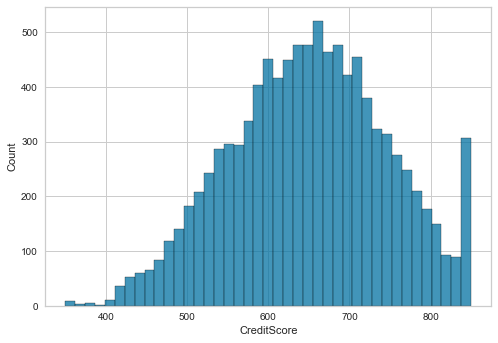

In [7]:
sns.histplot(clients.CreditScore)

<AxesSubplot:ylabel='CreditScore'>

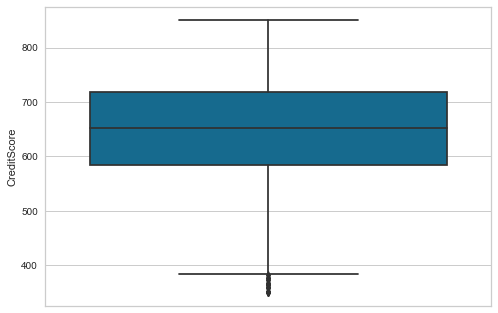

In [8]:
sns.boxplot(y=clients.CreditScore)

In [9]:
# Clients considered outliers
len(clients.CreditScore[clients.CreditScore<400])

19

<AxesSubplot:ylabel='CreditScore'>

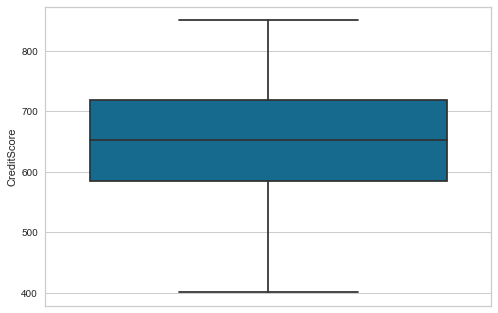

In [10]:
sns.boxplot(y=clients.CreditScore[clients.CreditScore>=400])

In [11]:
# Number of clients at cap of Credit Score
len(clients[clients.CreditScore==850])

233

In [12]:
clients.Geography.value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

<AxesSubplot:xlabel='Geography', ylabel='Count'>

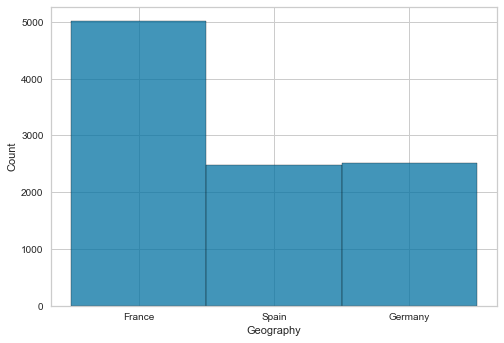

In [13]:
sns.histplot(clients.Geography)

In [14]:
# Coordinates
France=geocoder.osm('France')
Germany=geocoder.osm('Germany')
Spain=geocoder.osm('Spain')
# Variables and HeatMap plugin
France_int=[France.lat,France.lng,2000]
Germany_int=[Germany.lat,Germany.lng,2509*2000/5014]
Spain_int=[Spain.lat,Spain.lng,2477*2000/5014]
Countries=[France_int,Germany_int,Spain_int]
Map=folium.Map(location=[48,4],zoom_start=4)
plugins.HeatMap(Countries).add_to(Map)
Map

In [15]:
clients.groupby('Geography').mean()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
Geography,,,,,,,,,,
France,1.569065e+07,649.668329,38.511767,5.004587,62092.636516,1.530913,0.706621,0.516753,99899.180814,0.161548
Germany,1.569056e+07,651.453567,39.771622,5.009964,119730.116134,1.519729,0.713830,0.497409,101113.435102,0.324432
Spain,1.569192e+07,651.333872,38.890997,5.032297,61818.147763,1.539362,0.694792,0.529673,99440.572281,0.166734


In [16]:
# Reason for higher balance in Germany (?)
indicators=pd.DataFrame(index=['France','Germany','Spain'])
indicators['2020 PIB PC']=[33960,40490,23690]
indicators['2020 Debt PC']=[39296,27965,28396]
# https://datosmacro.expansion.com/paises/alemania
indicators['Debt/PIB']=round((indicators['2020 Debt PC']/indicators['2020 PIB PC'])*100,2)
indicators

,2020 PIB PC,2020 Debt PC,Debt/PIB
France,33960,39296,115.71
Germany,40490,27965,69.07
Spain,23690,28396,119.86


In [17]:
clients.Gender.value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

In [18]:
clients.groupby('Geography')['Gender'].value_counts()

Geography  Gender
France     Male      2753
           Female    2261
Germany    Male      1316
           Female    1193
Spain      Male      1388
           Female    1089
Name: Gender, dtype: int64

In [19]:
clients.groupby('Geography')['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Geography,,,,,,,,
France,5014.0,38.511767,10.469459,18.0,31.0,37.0,43.0,92.0
Germany,2509.0,39.771622,10.519143,18.0,32.0,38.0,45.0,84.0
Spain,2477.0,38.890997,10.446119,18.0,32.0,37.0,44.0,88.0


In [20]:
clients.groupby('Geography')['Tenure'].describe()

,count,mean,std,min,25%,50%,75%,max
Geography,,,,,,,,
France,5014.0,5.004587,2.888475,0.0,2.0,5.0,7.0,10.0
Germany,2509.0,5.009964,2.935154,0.0,2.0,5.0,8.0,10.0
Spain,2477.0,5.032297,2.856660,0.0,3.0,5.0,8.0,10.0


In [21]:
clients.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [22]:
clients.groupby('Geography')['Balance'].describe()
# Other possible explanation is that the German branch forces clients to have a minimun balance

,count,mean,std,min,25%,50%,75%,max
Geography,,,,,,,,
France,5014.0,62092.636516,64133.565524,0.00,0.00,62153.50,121444.8775,238387.56
Germany,2509.0,119730.116134,27022.006157,27288.43,102800.72,119703.10,137560.3800,214346.96
Spain,2477.0,61818.147763,64235.555208,0.00,0.00,61710.44,121056.6300,250898.09


<AxesSubplot:xlabel='Balance', ylabel='Count'>

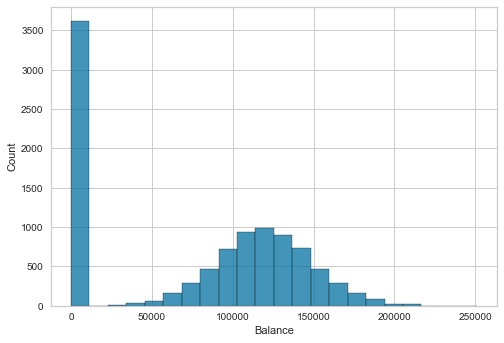

In [23]:
sns.histplot(clients.Balance)

In [24]:
clients[clients.Balance==0].describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,3.617000e+03,3617.000000,3617.000000,3617.000000,3617.0,3617.000000,3617.000000,3617.000000,3617.000000,3617.000000
mean,1.569195e+07,649.452861,38.434891,5.071330,0.0,1.784628,0.716616,0.517832,98983.559549,0.138236
std,7.194749e+04,96.158798,10.492002,2.860781,0.0,0.496455,0.450704,0.499751,57730.828955,0.345195
min,1.556571e+07,350.000000,18.000000,0.000000,0.0,1.000000,0.000000,0.000000,90.070000,0.000000
25%,1.562952e+07,583.000000,31.000000,3.000000,0.0,1.000000,0.000000,0.000000,49506.820000,0.000000
50%,1.569335e+07,651.000000,37.000000,5.000000,0.0,2.000000,1.000000,1.000000,98618.790000,0.000000
75%,1.575355e+07,717.000000,43.000000,7.000000,0.0,2.000000,1.000000,1.000000,148330.970000,0.000000
max,1.581536e+07,850.000000,88.000000,10.000000,0.0,4.000000,1.000000,1.000000,199992.480000,1.000000


In [25]:
# Nevermind what was done before, the reason is that there are a lot of accounts with no balance in
# France and Spain
clients[clients.Balance>0].groupby('Geography').mean()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
Geography,,,,,,,,,,
France,1.568982e+07,650.900231,38.611710,4.948767,119927.765597,1.297766,0.694530,0.512712,100625.034653,0.182203
Germany,1.569056e+07,651.453567,39.771622,5.009964,119730.116134,1.519729,0.713830,0.497409,101113.435102,0.324432
Spain,1.569112e+07,651.003912,39.261346,4.982786,119814.985923,1.302817,0.679969,0.546948,100127.281135,0.195618


In [26]:
print('Clients with positive balance:',len(clients[clients.Balance>0]))
print('Clients with balance 0:',len(clients[clients.Balance==0]))

Clients with positive balance: 6383
Clients with balance 0: 3617


<AxesSubplot:xlabel='NumOfProducts', ylabel='Count'>

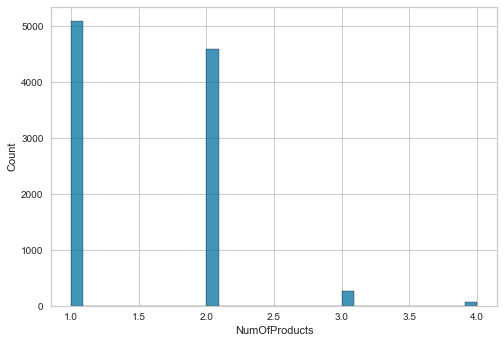

In [27]:
sns.histplot(clients.NumOfProducts)

In [28]:
clients.HasCrCard.value_counts()

1    7055
0    2945
Name: HasCrCard, dtype: int64

In [29]:
clients.IsActiveMember.value_counts()

1    5151
0    4849
Name: IsActiveMember, dtype: int64

<AxesSubplot:xlabel='EstimatedSalary', ylabel='Count'>

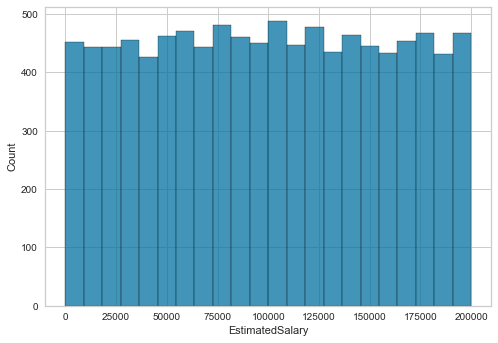

In [30]:
sns.histplot(clients.EstimatedSalary)

In [31]:
clients.groupby('Geography')['EstimatedSalary'].describe()

,count,mean,std,min,25%,50%,75%,max
Geography,,,,,,,,
France,5014.0,99899.180814,57336.289016,90.07,51399.19,99132.31,149295.36,199929.17
Germany,2509.0,101113.435102,58263.011501,11.58,51016.02,102397.22,151083.80,199970.74
Spain,2477.0,99440.572281,57103.678091,417.41,50267.69,99984.86,147278.43,199992.48


In [32]:
clients[clients.EstimatedSalary<20]

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
2363,15791053,Lucciano,709,Germany,Male,45,4,122917.71,1,1,1,11.58,1


In [33]:
clients.groupby(['Geography','Exited']).agg({'Exited':'count','Tenure':'mean','Balance':'mean'})

Exited    Tenure        Balance
Geography Exited                                 
France    0         4204  5.005471   60339.275678
          1          810  5.000000   71192.795728
Germany   0         1695  5.011799  119427.106696
          1          814  5.006143  120361.075590
Spain     0         2064  5.107558   59678.070470
          1          413  4.656174   72513.352446

In [34]:
clients[clients.Balance==0].groupby(['Geography','Exited']).count()['CustomerId']

Geography  Exited
France     0         2081
           1          337
Spain      0         1036
           1          163
Name: CustomerId, dtype: int64

# Unsupervised Model

In [35]:
clients=clients[clients.CreditScore>400]

In [36]:
clients.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [37]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9981 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       9981 non-null   int64  
 1   Surname          9981 non-null   object 
 2   CreditScore      9981 non-null   int64  
 3   Geography        9981 non-null   object 
 4   Gender           9981 non-null   object 
 5   Age              9981 non-null   int64  
 6   Tenure           9981 non-null   int64  
 7   Balance          9981 non-null   float64
 8   NumOfProducts    9981 non-null   int64  
 9   HasCrCard        9981 non-null   int64  
 10  IsActiveMember   9981 non-null   int64  
 11  EstimatedSalary  9981 non-null   float64
 12  Exited           9981 non-null   int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


In [38]:
All_Clients=clients.drop(['CustomerId','Surname','Geography','Exited'],axis=1)
All_Clients=pd.get_dummies(All_Clients, columns=['Gender'], drop_first=True)
All_Clients=All_Clients.reset_index(drop=True)

In [39]:
All_Clients.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,0
1,608,41,1,83807.86,1,0,1,112542.58,0
2,502,42,8,159660.80,3,1,0,113931.57,0
3,699,39,1,0.00,2,0,0,93826.63,0
4,850,43,2,125510.82,1,1,1,79084.10,0


In [40]:
scaler = StandardScaler()
Scaled_All_Clients = pd.DataFrame(scaler.fit_transform(All_Clients[['CreditScore','Age','Tenure','Balance','EstimatedSalary']]),columns=['CreditScore','Age','Tenure','Balance','EstimatedSalary'])
Scaled_All_Clients['NumOfProducts']=All_Clients['NumOfProducts']
Scaled_All_Clients['HasCrCard']=All_Clients['HasCrCard']
Scaled_All_Clients['IsActiveMember']=All_Clients['IsActiveMember']
Scaled_All_Clients['Gender_Male']=All_Clients['Gender_Male']
columns=All_Clients.columns.to_list()
Scaled_All_Clients=Scaled_All_Clients[columns]
Scaled_All_Clients.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male
0,-0.334227,0.294389,-1.042639,-1.225277,1,1,1,0.022800,0
1,-0.448876,0.199036,-1.388499,0.117823,1,0,1,0.217412,0
2,-1.553673,0.294389,1.032521,1.333437,3,1,0,0.241560,0
3,0.499582,0.008331,-1.388499,-1.225277,2,0,0,-0.107980,0
4,2.073397,0.389742,-1.042639,0.786152,1,1,1,-0.364291,0


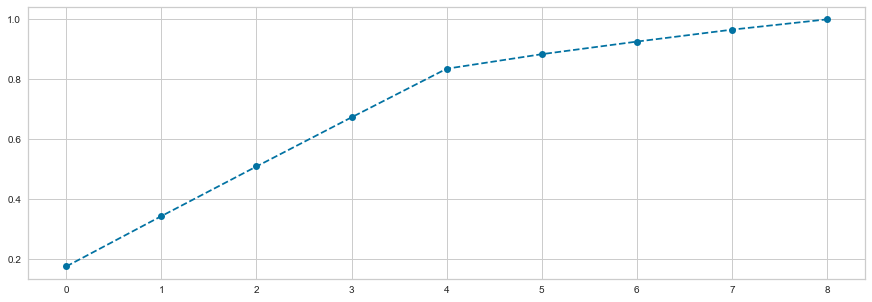

In [41]:
pca = PCA().fit(Scaled_All_Clients)
plt.figure(figsize=(15, 5))
plt.plot(pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')

In [42]:
Components_All_Clients=PCA(n_components=4).fit_transform(Scaled_All_Clients)
DFC_All_Clients = pd.DataFrame(Components_All_Clients)
DFC_All_Clients.head()

,0,1,2,3
0,-0.529017,0.959406,0.072854,-0.813474
1,0.633208,0.623954,0.211948,-1.204921
2,0.550876,-0.605434,1.824613,0.597786
3,-0.741483,0.996306,-0.865945,-1.042755
4,1.339597,0.339131,-2.141330,-0.155738


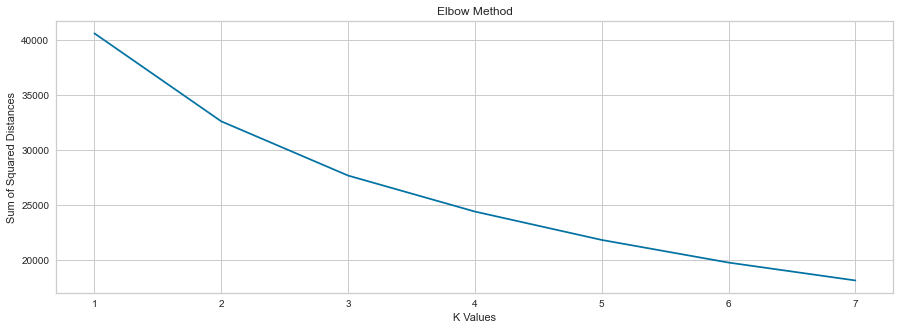

In [43]:
K = range(1, 8)
sum_squared_distances = []
for k in K:
    model = KMeans(n_clusters=k).fit(DFC_All_Clients)
    sum_squared_distances.append(model.inertia_)
plt.figure(figsize=(15, 5))
plt.plot(K, sum_squared_distances)
plt.xlabel('K Values')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method')
plt.show()

In [44]:
for i in range(2,15):
    kmeans=KMeans(n_clusters=i)
    kmeans.fit(DFC_All_Clients)
    score=silhouette_score(DFC_All_Clients,kmeans.labels_)
    print('Clusters:',i)
    print('Score',score)

Clusters: 2
Score 0.19880827812147278
Clusters: 3
Score 0.19356775686061847
Clusters: 4
Score 0.18470611235003312
Clusters: 5
Score 0.19082674745677447
Clusters: 6
Score 0.19125663663769557
Clusters: 7
Score 0.19734039669521147
Clusters: 8
Score 0.19884408792167887
Clusters: 9
Score 0.19878468651966225
Clusters: 10
Score 0.20272047453178177
Clusters: 11
Score 0.20086489171758637
Clusters: 12
Score 0.2041715523886487
Clusters: 13
Score 0.19612020381254255
Clusters: 14
Score 0.1959704072199101


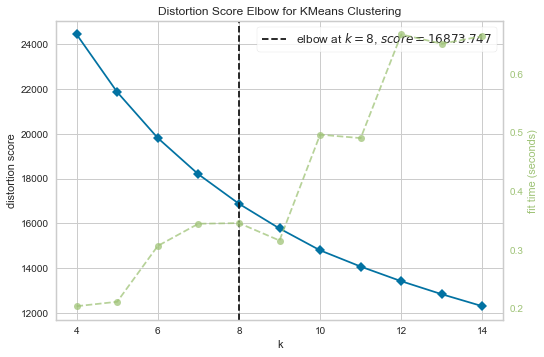

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [45]:
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(4,15))
visualizer.fit(DFC_All_Clients)
visualizer.show()

In [46]:
kmeans=KMeansConstrained(
    n_clusters=5,
    size_min=1996,
    random_state=42
)
#kmeans=KMeans(n_clusters=5,random_state=42)
All_Clients_clusters=kmeans.fit_predict(DFC_All_Clients)
All_Clients['labels']=All_Clients_clusters
All_Clients['labels'].value_counts()

0    1997
1    1996
2    1996
3    1996
4    1996
Name: labels, dtype: int64

In [47]:
All_Clients.groupby('labels').mean()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male
labels,,,,,,,,,
0,642.836755,36.505258,2.116675,118032.367126,1.364547,0.690035,0.529294,129412.616765,0.544817
1,643.658317,49.235471,4.939379,107559.009905,1.379259,0.704409,0.584669,50812.540020,0.545090
2,737.840681,35.003006,4.550100,21943.168252,1.751503,0.707916,0.502505,84281.797911,0.538577
3,666.785070,37.934369,7.760521,119276.575802,1.394790,0.712926,0.469439,136186.445706,0.550601
4,564.220942,35.886273,5.707916,15447.381363,1.762024,0.710922,0.491483,99479.128472,0.550601


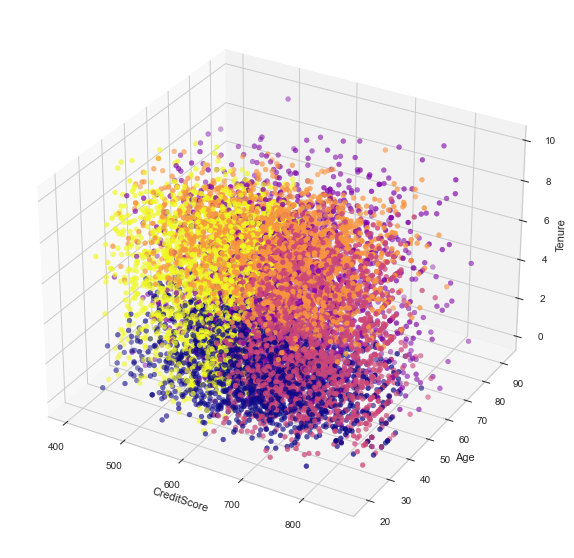

In [48]:
fig = plt.figure(num=None, figsize=(15, 10), facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")
ax.scatter3D(All_Clients['CreditScore'],All_Clients['Age'],All_Clients['Tenure'],s=25,
             c=All_Clients['labels'], cmap='plasma')
xLabel = ax.set_xlabel('CreditScore', linespacing=3.2)
yLabel = ax.set_ylabel('Age', linespacing=3.1)
zLabel = ax.set_zlabel('Tenure', linespacing=3.4)

In [76]:
#Creamos el lienzo del grafico
escena=dict(xaxis=dict(title='Puntaje Crediticio'),yaxis=dict(title='Edad'),zaxis=dict(title='Tiempo en el Banco'))
#Graficamos los puntitos
puntitos=go.Scatter3d(x=All_Clients['CreditScore'],y=All_Clients['Age'],z=All_Clients['Tenure'],
                      mode='markers',marker=dict(color=All_Clients['labels'],colorscale='plasma',
                                                 size=10,
                                                 line=dict(color='gray',width=5)))
#Layout de nuestra escena
layout=go.Layout(margin=dict(l=0,r=0),scene=escena,height=1000,width=1000)
data=[puntitos]
#Unimos lienzo, layout y datos
fig=go.Figure(data=data,layout=layout)
fig.show()

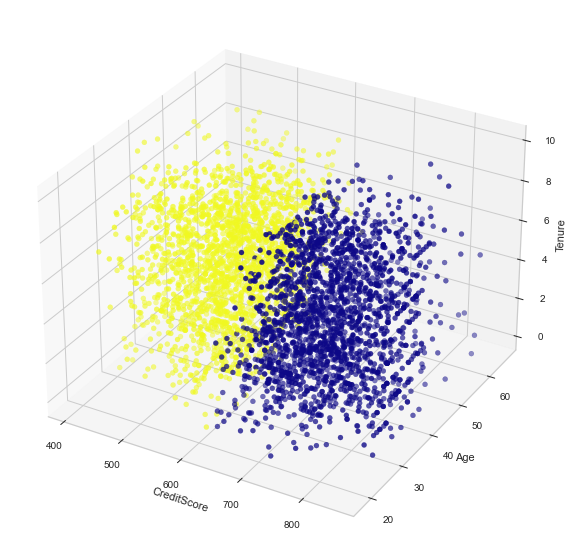

In [68]:
fig = plt.figure(num=None, figsize=(15, 10), facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")
ax.scatter3D(All_Clients[All_Clients.labels.isin([2,4])]['CreditScore'],
             All_Clients[All_Clients.labels.isin([2,4])]['Age'],
             All_Clients[All_Clients.labels.isin([2,4])]['Tenure'],s=25,
             c=All_Clients[All_Clients.labels.isin([2,4])]['labels'], cmap='plasma')
xLabel = ax.set_xlabel('CreditScore', linespacing=3.2)
yLabel = ax.set_ylabel('Age', linespacing=3.1)
zLabel = ax.set_zlabel('Tenure', linespacing=3.4)

In [73]:
escena=dict(xaxis=dict(title='Puntaje Crediticio'),yaxis=dict(title='Edad'),zaxis=dict(title='Tiempo en el Banco'))
puntitos=go.Scatter3d(x=All_Clients[All_Clients.labels.isin([2,4])]['CreditScore'],
                      y=All_Clients[All_Clients.labels.isin([2,4])]['Age'],
                      z=All_Clients[All_Clients.labels.isin([2,4])]['Tenure'],
                      mode='markers',
                      marker=dict(color=All_Clients[All_Clients.labels.isin([2,4])]['labels'],
                                  colorscale='plasma',size=10,
                                  line=dict(color='gray',width=5)))
layout=go.Layout(margin=dict(l=0,r=0),scene=escena,height=1000,width=1000)
data=[puntitos]
fig=go.Figure(data=data,layout=layout)
fig.show()

In [74]:
escena=dict(xaxis=dict(title='Puntaje Crediticio'),yaxis=dict(title='Edad'),zaxis=dict(title='Tiempo en el Banco'))
puntitos=go.Scatter3d(x=All_Clients[All_Clients.labels.isin([0,1,3])]['CreditScore'],
                      y=All_Clients[All_Clients.labels.isin([0,1,3])]['Age'],
                      z=All_Clients[All_Clients.labels.isin([0,1,3])]['Tenure'],
                      mode='markers',
                      marker=dict(color=All_Clients[All_Clients.labels.isin([0,1,3])]['labels'],
                                  colorscale='plasma',size=10,
                                  line=dict(color='gray',width=5)))
layout=go.Layout(margin=dict(l=0,r=0),scene=escena,height=1000,width=1000)
data=[puntitos]
fig=go.Figure(data=data,layout=layout)
fig.show()

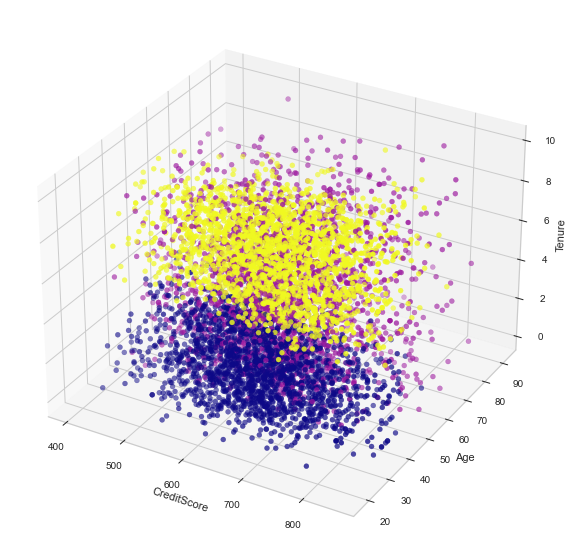

In [52]:
fig = plt.figure(num=None, figsize=(15, 10), facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")
ax.scatter3D(All_Clients[All_Clients.labels.isin([0,1,3])]['CreditScore'],
             All_Clients[All_Clients.labels.isin([0,1,3])]['Age'],
             All_Clients[All_Clients.labels.isin([0,1,3])]['Tenure'],s=25,
             c=All_Clients[All_Clients.labels.isin([0,1,3])]['labels'], cmap='plasma')
xLabel = ax.set_xlabel('CreditScore', linespacing=3.2)
yLabel = ax.set_ylabel('Age', linespacing=3.1)
zLabel = ax.set_zlabel('Tenure', linespacing=3.4)

In [53]:
escena=dict(xaxis=dict(title='CreditScore'),yaxis=dict(title='Age'),zaxis=dict(title='Tenure'))
puntitos=go.Scatter3d(x=All_Clients[All_Clients.labels.isin([0,1,3])]['CreditScore'],
                      y=All_Clients[All_Clients.labels.isin([0,1,3])]['Age'],
                      z=All_Clients[All_Clients.labels.isin([0,1,3])]['Tenure'],
                      mode='markers',
                      marker=dict(color=All_Clients[All_Clients.labels.isin([0,1,3])]['labels'],
                                  colorscale='plasma',showscale=True,size=10,
                                  line=dict(color='gray',width=5)))
layout=go.Layout(margin=dict(l=0,r=0),scene=escena,height=1000,width=1000)
data=[puntitos]
fig=go.Figure(data=data,layout=layout)
fig.show()

# Supervised Model

In [54]:
All_Clients_With_Y=pd.concat([All_Clients,clients['Exited'].reset_index(drop=True).to_frame()],axis=1)

In [55]:
def lr_test(cluster):
    X=All_Clients_With_Y[All_Clients_With_Y['labels']==cluster].drop(['Exited','labels'],axis=1)
    y=All_Clients_With_Y[All_Clients_With_Y['labels']==cluster]['Exited'].to_frame()
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
    logreg = LogisticRegression()
    logreg.fit(X_train,y_train.values.ravel())
    y_pred = logreg.predict(X_test)
    cm=confusion_matrix(y_test, y_pred)
    ascore=accuracy_score(y_test, y_pred)
    return cm,ascore

In [56]:
total=0
for i in range(0,5):
    a,b=lr_test(i)
    print('Cluster',i,'->',b)
    total=total+b
total

Cluster 0 -> 0.795
Cluster 1 -> 0.6925
Cluster 2 -> 0.9075
Cluster 3 -> 0.79
Cluster 4 -> 0.8475


4.0325

In [57]:
def nei_test(cluster):
    X=All_Clients_With_Y[All_Clients_With_Y['labels']==cluster].drop(['Exited','labels'],axis=1)
    y=All_Clients_With_Y[All_Clients_With_Y['labels']==cluster]['Exited'].to_frame()
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
    neighbors = KNeighborsClassifier(n_neighbors=2)
    neighbors.fit(X_train,y_train.values.ravel())
    y_pred = neighbors.predict(X_test)
    cm=confusion_matrix(y_test, y_pred)
    ascore=accuracy_score(y_test, y_pred)
    return cm,ascore

In [58]:
total=0
for i in range(0,5):
    a,b=nei_test(i)
    print('Cluster',i,'->',b)
    total=total+b
total

Cluster 0 -> 0.7825
Cluster 1 -> 0.63
Cluster 2 -> 0.9
Cluster 3 -> 0.7525
Cluster 4 -> 0.8325


3.8975

In [59]:
def gau_test(cluster):
    X=All_Clients_With_Y[All_Clients_With_Y['labels']==cluster].drop(['Exited','labels'],axis=1)
    y=All_Clients_With_Y[All_Clients_With_Y['labels']==cluster]['Exited'].to_frame()
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
    gaussiannei = GaussianNB()
    gaussiannei.fit(X_train,y_train.values.ravel())
    y_pred = gaussiannei.predict(X_test)
    cm=confusion_matrix(y_test, y_pred)
    ascore=accuracy_score(y_test, y_pred)
    return cm,ascore

In [60]:
total=0
for i in range(0,5):
    a,b=gau_test(i)
    print('Cluster',i,'->',b)
    total=total+b
total

Cluster 0 -> 0.78
Cluster 1 -> 0.71
Cluster 2 -> 0.9125
Cluster 3 -> 0.7875
Cluster 4 -> 0.8425


4.0325

In [61]:
def tree_test(cluster):
    X=All_Clients_With_Y[All_Clients_With_Y['labels']==cluster].drop(['Exited','labels'],axis=1)
    y=All_Clients_With_Y[All_Clients_With_Y['labels']==cluster]['Exited'].to_frame()
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
    tree = DecisionTreeClassifier()
    tree.fit(X_train,y_train.values.ravel())
    y_pred = tree.predict(X_test)
    cm=confusion_matrix(y_test, y_pred)
    ascore=accuracy_score(y_test, y_pred)
    return cm,ascore

In [62]:
total=0
for i in range(0,5):
    a,b=tree_test(i)
    print('Cluster',i,'->',b)
    total=total+b
total

Cluster 0 -> 0.7475
Cluster 1 -> 0.7
Cluster 2 -> 0.8775
Cluster 3 -> 0.7325
Cluster 4 -> 0.83


3.8875

In [63]:
def vector_test(cluster):
    X=All_Clients_With_Y[All_Clients_With_Y['labels']==cluster].drop(['Exited','labels'],axis=1)
    y=All_Clients_With_Y[All_Clients_With_Y['labels']==cluster]['Exited'].to_frame()
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
    vec = SVC()
    vec.fit(X_train,y_train.values.ravel())
    y_pred = vec.predict(X_test)
    cm=confusion_matrix(y_test, y_pred)
    ascore=accuracy_score(y_test, y_pred)
    return cm,ascore

In [64]:
total=0
for i in range(0,5):
    a,b=vector_test(i)
    print('Cluster',i,'->',b)
    total=total+b
total

Cluster 0 -> 0.795
Cluster 1 -> 0.6925
Cluster 2 -> 0.9075
Cluster 3 -> 0.785
Cluster 4 -> 0.85


4.03

# Churn

In [65]:
def survival(data: pd.DataFrame, group_field: str, time_field: str, event_field: str) -> tuple:
    """
  Función que recibe un DF y filtra por columna a partir del campo de 
  agrupación. 

  Regresa
    Plot de Función de Supervivencia
    Test de Logrank
    """
    model = KaplanMeierFitter()
    results = []
    con_exp = []
    for i in data[group_field].unique():
        group = data[data[group_field] == i]
        T = group[time_field]
        E = group[event_field]
        con_exp.append([T, E])
        model.fit(T, E, label=str(i))
        results.append(model.survival_function_)
    survival = pd.concat(results, axis=1)
    log_result = logrank_test(con_exp[0][0], con_exp[1][0], 
                            event_observed_A=con_exp[0][1], 
                            event_observed_B=con_exp[1][1])
    return survival, log_result

In [66]:
rates, logrank = survival(All_Clients_With_Y,'labels','Tenure','Exited')

In [89]:
print(logrank)
rates.plot(kind='line', title='Tasa de Retención de Clientes por Perfil',
           labels=dict(value='Tasa de retención', timeline='Retención (Años)'))

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         429.64 <0.005    314.62
